<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ДЗ:-Временные-ряды" data-toc-modified-id="ДЗ:-Временные-ряды-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ДЗ: Временные ряды</a></span><ul class="toc-item"><li><span><a href="#anti-diabetic-drugs" data-toc-modified-id="anti-diabetic-drugs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>anti-diabetic-drugs</a></span></li><li><span><a href="#female-births" data-toc-modified-id="female-births-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>female-births</a></span></li><li><span><a href="#shampoo" data-toc-modified-id="shampoo-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>shampoo</a></span></li></ul></li></ul></div>

# ДЗ: Временные ряды



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)

In [ ]:
import statsmodels.api as sm # все, для работы с рядами
from scipy.special import inv_boxcox # обратное преобразование Бокса-Кокса 
from itertools import product # произведения множеств
import warnings # чтобы отключить предупреждения в Python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Есть 3 датасета с временными рядами
- В `anti-diabetic-drugs.csv` содержатся данные о ежемесячных продажах антидиабетических препаратов в Австралии с 1992 по 2008 год. 
- В `female-births.csv` содержатся данные о количестве новорожденных детей женского пола в 1959 году в Калифорнии. 
- В `shampoo.csv` содержатся данные о ежемесячных продажах шампуня за трехлетний период. 


Проанализируйте каждый из этих рядов и постройте модель SARIMA, чтобы сделать прогноз
- для `anti-diabetic-drugs.csv` - на один год вперед
- для `female-births.csv` - на один месяц вперед
- для `shampoo.csv` - на 3 месяца вперед

Для этого 
- рассмотрите необходимость стабилизации дисперссии и необходимость дифференцирования ряда
- проанализируйте ACF и PACF и подберите гиперпараметры SARIMA
- обучите модель SARIMA с наилучшими гиперпараметрами
- проанализируйте остатки модели

Ваши решения необходимо сопроводить краткими комментариями и выводами, которые Вы сделали на основе анализа. Не забывайте о построении графиков! 

Ориентируйтесь на пример анализа временного ряда в ноутбуке с последнего занятия.

**ВАЖНОЕ СООБЩЕНИЕ:** при построении прогноза и заполнении таблицы *предсказанными* значениями не выполнялась процедура обратного Бокса-Кокса, т.к значения становятся либо слишком большими, либо предсказание становится константным.

## anti-diabetic-drugs

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


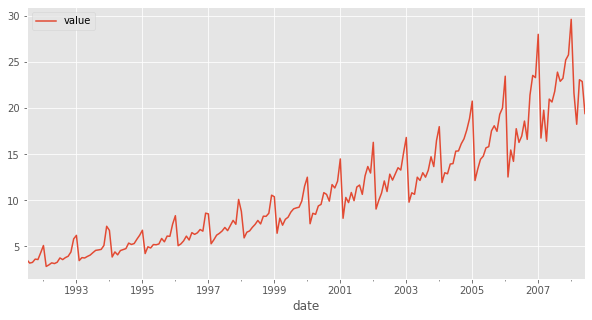

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Math & Natural & Finance/Math/Statistics/data/anti-diabetic-drugs.csv', index_col='date', parse_dates=['date'])
df.plot();
df.head()

In [ ]:
from statsmodels.tsa.stattools import adfuller
X = df.value
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.145186
p-value: 1.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


Тест Дики-Фуллера показал, что ряд *нестационарен* (`p-value = 1` - не отвергаем нулевую гипотезу о нестационарности): виден устойчивый возрастающий тренд и рост диспепрсии с течением времени; видна сезонность от года к году.

Графики Автокорреляции и Частной автокорреляции подверждают эти выводы: видна медленно угасающая зависимость от далее расположенных наблюдений и (в меньшей степени) проявление сезонности на лагах $12-24-36$ на графике Автокорреляционной функции: 

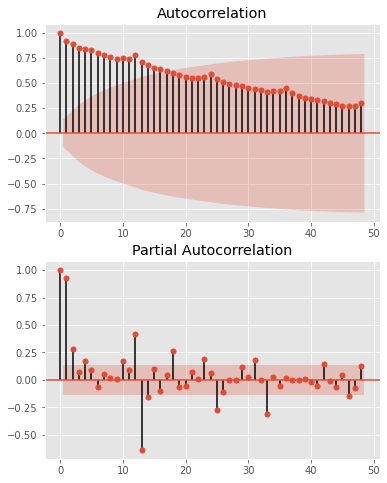

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(6,8)) 

sm.graphics.tsa.plot_acf(df['value'], lags=48, ax=ax1)
sm.graphics.tsa.plot_pacf(df['value'], lags=48, ax=ax2)

plt.show()

Стабилизировать дисперсию мы будем с помощью преобразованися [Бокса-Кокса](https://www.statisticshowto.com/box-cox-transformation/), которое подбирает оптимальный параметр $\lambda$:

In [ ]:
df['value_var'], lmbd = stats.boxcox(df['value'])

In [ ]:
print("Оптимальный параметр преобразования Бокса-Кокса: ",lmbd)

Оптимальный параметр преобразования Бокса-Кокса:  0.061505584870954325


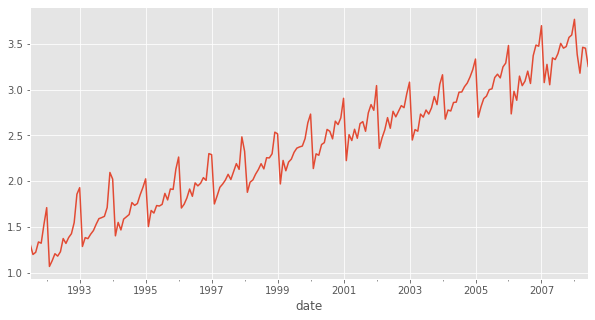

In [ ]:
df.value_var.plot()

По сравнению с изначальным графиком дисперсия стабилизировалась - остались сезонность и тренд. От них можно избавиться, применив дифференциирование (разности соседних наблюдений).

Мы уже определили по графику, что наша сезонность с лагом $12$:

In [ ]:
df['value_diff'] = df.value_var - df.value_var.shift(12)

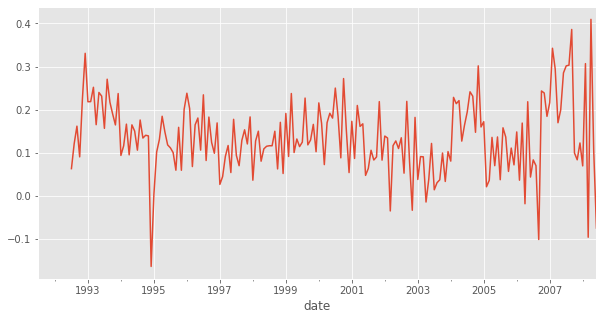

In [ ]:
df.value_diff.plot()

Тренд пропал, как и сезонность. Разброс значений сконцентрирован возле нуля.

Проверим наш заключение формально: проведём ещё один тест Дики-Фуллера:

In [ ]:
result = adfuller(df.value_diff[13:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.215993
p-value: 0.000008
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


Тест Дики-Фуллера показал, что ряд *стационарен* (`p-value = 0` - отвергнем нулевую гипотезу о нестационарности).

Чтобы выбрать начальные значения для $p,q$ и $P,Q$, необходимо построить графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF).

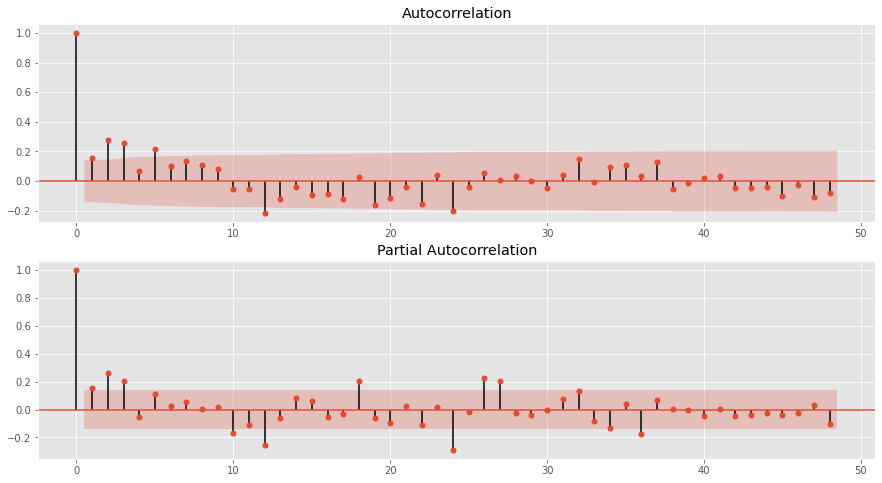

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(df.value_diff[13:].values.squeeze(), lags=48, ax=ax1)
sm.graphics.tsa.plot_pacf(df.value_diff[13:].values.squeeze(), lags=48, ax=ax2)

plt.show()

**PACF**: $p = 3$, $P = 3$  
**ACF**: $q = 3$, $Q = 1$

In [ ]:
# создадим список из значений параметров для перебора моделей

s = 12 # сезонность
d = D = 1
ps = range(0, 3+1)
qs = range(0, 3+1)

Ps = range(0, 2+1)
Qs = range(0, 1+1)

parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# SARIMAX(p,d,q)x(P,D,Q,s)
results = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in tqdm(parameters_list):
    #try-except нужен, чтобы обработать случаи, когда модель не обучается
    p, q, P, Q = param
    try:
        model=sm.tsa.statespace.SARIMAX(df.value,  #sales_boxcox или sales
            order=(p, d, q), 
            seasonal_order=(P, D, Q, s)).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

  0%|          | 0/96 [00:00<?, ?it/s]

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']

result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
88,"(3, 2, 2, 0)",519.082236
85,"(3, 2, 0, 1)",520.312874
94,"(3, 3, 2, 0)",520.879670
89,"(3, 2, 2, 1)",520.914490
22,"(0, 3, 2, 0)",521.647134


Лучшей моделью получилась вторая модель **SARIMA (3,1,2)x(0,1,1)**: критерий AIC соизмерим у первой и второй модели, но вторая более простая модель.

In [ ]:
best_model = sm.tsa.statespace.SARIMAX(df.value, 
                                     order=(3,1,2), 
                                     seasonal_order=(0,1,1,12)).fit(disp=-1)

In [ ]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  204
Model:             SARIMAX(3, 1, 2)x(0, 1, 1, 12)   Log Likelihood                -253.156
Date:                            Mon, 04 Jul 2022   AIC                            520.313
Time:                                    08:27:50   BIC                            543.079
Sample:                                07-01-1991   HQIC                           529.534
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6983      0.147     -4.747      0.000      -0.987      -0.410
ar.L2          0.2046      0.136   

Последний этап - это проанализировать residuals. Нужно показать, что остатки несмещены, стационарны и неавтокоррелированы. 

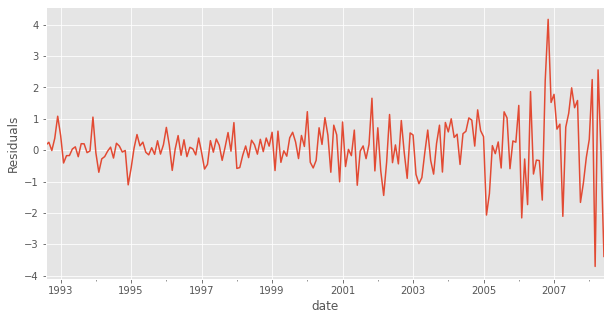

In [ ]:
best_model.resid[13:].plot()
plt.ylabel('Residuals')
plt.show()

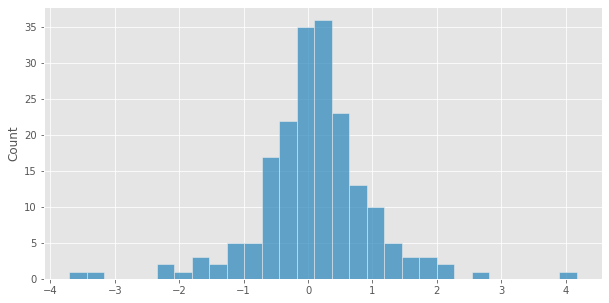

In [ ]:
sns.histplot(best_model.resid[13:]);

Визуально остатки выглядят неплохо. Но видны некоторые признаки нестационарности: по графику видно, что модель хуже предсказывает значения в конце выборки. Возможно, они единичны, поэтому их влияние минорно.

**Несмещенность.** Проверим несмещенность с помощью критерия знаков (самый универсальный критерий).

In [ ]:
from statsmodels.stats.descriptivestats import sign_test
print("Критерий знаков для остатков: pvalue =",
      sign_test(best_model.resid[13:])[1])

Критерий знаков для остатков: pvalue = 0.24690960012758428


Нулевая гипотеза (одно распределение) не отвергается - остатки несмещены.

**Стационарность.** Проверим стационарность с помщью критерия Дики-Фуллера.

In [ ]:
print("Критерий Дики-Фуллера для остатков: pvalue =",
      sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Дики-Фуллера для остатков: pvalue = 6.923228583635149e-25


Отвергаем нулевую гипотезу (нестационарность).

**Неавтокоррелированность.** Чтобы определить независимость остаткок, посмотрим на график автокорреляционной функции.

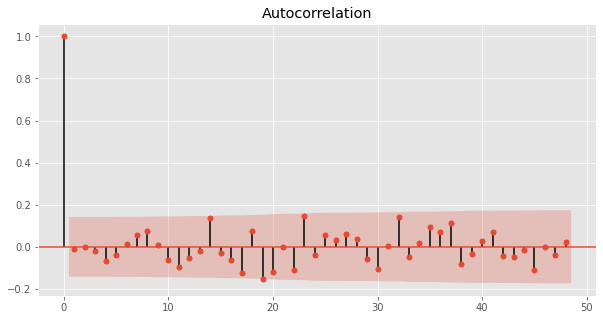

In [ ]:
#plt.figure(figsize(16,5))
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48)
plt.show()

Все остатки статистически не отличимы от нуля.

**Итого:** по всем трём формальным тестам остатков наша модель модет быть засчитана как хорошая.

In [ ]:
df.tail()

,value,value_var,value_diff
date,,,
2008-02-01,21.654285,3.385265,0.306853
2008-03-01,18.264945,3.180677,-0.096285
2008-04-01,23.107677,3.463910,0.409604
2008-05-01,22.912510,3.453623,0.105350
2008-06-01,19.431740,3.254856,-0.074925


In [ ]:
# прогноз на 12м вперёд
import datetime
from dateutil.relativedelta import relativedelta

df['model'] = best_model.fittedvalues #inv_boxcox(best_model.fittedvalues, lmbd) 
plot_data = df[['value', 'model']]

date_list = [datetime.datetime.strptime("2008-07-01", "%Y-%m-%d") + relativedelta(months=x) 
             for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= plot_data.columns)
plot_data = pd.concat([plot_data, future])

plot_data.tail()

,value,model
2009-02-01,NaN,NaN
2009-03-01,NaN,NaN
2009-04-01,NaN,NaN
2009-05-01,NaN,NaN
2009-06-01,NaN,NaN


In [ ]:
df.shape[0]

204

In [ ]:
forecast = best_model.predict(start=df.shape[0], end=df.shape[0]+11) #inv_boxcox(best_model.predict(start=df.shape[0], end=df.shape[0]+11), lmbd)
forecast.index = date_list

plot_data.loc[date_list, 'model'] = forecast

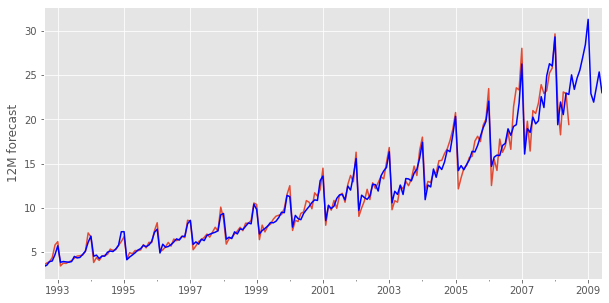

In [ ]:
plot_data.value[13:].plot()
plot_data.model[13:].plot(color='b')
plt.ylabel('12M forecast')
plt.show()

## female-births

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


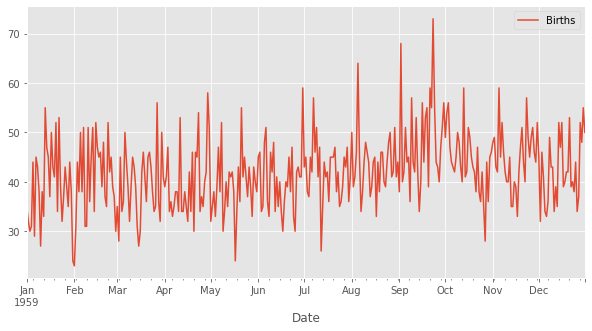

In [ ]:
df_1 = pd.read_csv('/content/drive/MyDrive/Math & Natural & Finance/Math/Statistics/data/female-births.csv', index_col=['Date'], parse_dates=['Date'])
df_1.plot();
df_1.head()

In [ ]:
from statsmodels.tsa.stattools import adfuller
X = df_1.Births
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.808291
p-value: 0.000052
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


Тест Дики-Фуллера показал, что ряд *стационарен* (`p-value = 0` - отвергаем нулевую гипотезу о нестационарности): отсутствует сезонность, тренд и изменяющаяся дисперсия.

Мы уже определили по графику, что наша сезонность с лагом $12$:

In [ ]:
df_1['Births_diff'] = df_1.Births - df_1.Births.shift(7)

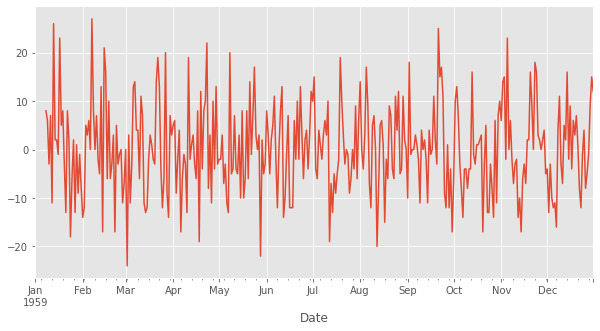

In [ ]:
df_1.Births_diff.plot()

Графики Автокорреляции и Частной автокорреляции подверждают эти выводы. Статистически ненулевая связь, вообще говоря, только со следующим наблюдением.

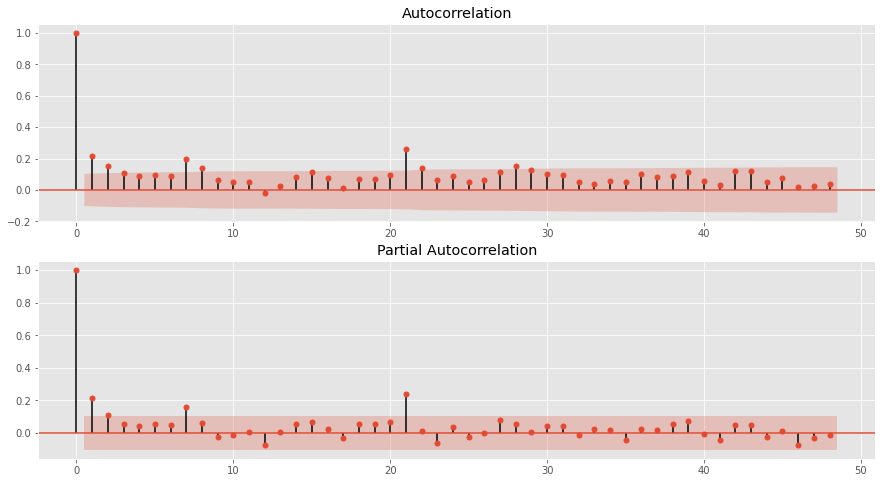

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(df_1.Births.values.squeeze(), lags=48, ax=ax1)
sm.graphics.tsa.plot_pacf(df_1.Births.values.squeeze(), lags=48, ax=ax2)

plt.show()

**PACF**: $p = 2$, $P = 1$  
**ACF**: $q = 3$, $Q = 2$

In [ ]:
# создадим список из значений параметров для перебора моделей

s = 12 # сезонность
d = D = 1
ps = range(0, 2+1)
qs = range(0, 3+1)

Ps = range(0, 1+1)
Qs = range(0, 2+1)

parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# SARIMAX(p,d,q)x(P,D,Q,s)
results = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in tqdm(parameters_list):
    #try-except нужен, чтобы обработать случаи, когда модель не обучается
    p, q, P, Q = param
    try:
        model=sm.tsa.statespace.SARIMAX(df_1.Births, ### Achtung!!! Bitte, vergessen Sie nicht das DF zu verändern.
            order=(p, d, q), 
            seasonal_order=(P, D, Q, s)).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']

result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
32,"(1, 1, 0, 2)",2423.201247
34,"(1, 1, 1, 1)",2423.317171
14,"(0, 2, 0, 2)",2423.558428
16,"(0, 2, 1, 1)",2423.692172
20,"(0, 3, 0, 2)",2424.468272


Лучшей моделью получилась вторая модель **SARIMA (1,0,1)x(0,0,2)**.

In [ ]:
best_model_1 = sm.tsa.statespace.SARIMAX(df_1.Births, 
                                     order=(1,0,1), 
                                     seasonal_order=(0,0,2,7)).fit(disp=-1)

In [ ]:
print(best_model_1.summary())

                                 Statespace Model Results                                
Dep. Variable:                            Births   No. Observations:                  365
Model:             SARIMAX(1, 0, 1)x(0, 0, 2, 7)   Log Likelihood               -1231.341
Date:                           Mon, 04 Jul 2022   AIC                           2472.683
Time:                                   08:34:24   BIC                           2492.182
Sample:                               01-01-1959   HQIC                          2480.432
                                    - 12-31-1959                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   5498.993      0.000       1.000       1.000
ma.L1         -0.9558      0.018    -53.592

Последний этап - это проанализировать residuals. Нужно показать, что остатки несмещены, стационарны и неавтокоррелированы. 

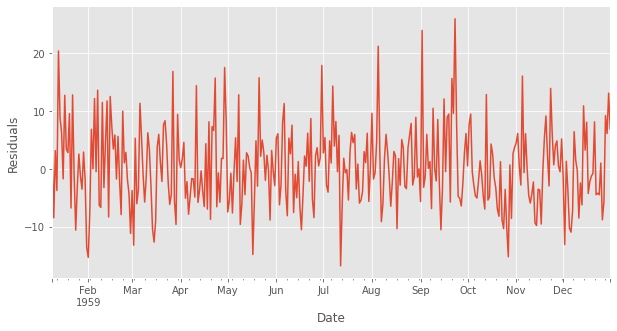

In [ ]:
best_model_1.resid[8:].plot()
plt.ylabel('Residuals')
plt.show()

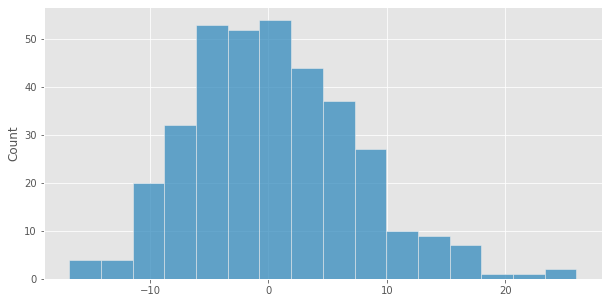

In [ ]:
sns.histplot(best_model_1.resid[8:]);

Визуально остатки выглядят неплохо. Но видны некоторые признаки нестационарности: по графику видно, что модель хуже предсказывает значения в конце выборки. Возможно, они единичны, поэтому их влияние минорно.

**Несмещенность.** Проверим несмещенность с помощью критерия знаков (самый универсальный критерий).

In [ ]:
from statsmodels.stats.descriptivestats import sign_test
print("Критерий знаков для остатков: pvalue =",
      sign_test(best_model_1.resid[8:])[1])

Критерий знаков для остатков: pvalue = 0.5254164863560933


Нулевая гипотеза (одно распределение) не отвергается - остатки несмещены.

**Стационарность.** Проверим стационарность с помщью критерия Дики-Фуллера.

In [ ]:
print("Критерий Дики-Фуллера для остатков: pvalue =",
      sm.tsa.stattools.adfuller(best_model_1.resid[8:])[1])

Критерий Дики-Фуллера для остатков: pvalue = 1.2396810544741192e-29


Отвергаем нулевую гипотезу (нестационарность).

**Неавтокоррелированность.** Чтобы определить независимость остаткок, посмотрим на график автокорреляционной функции.

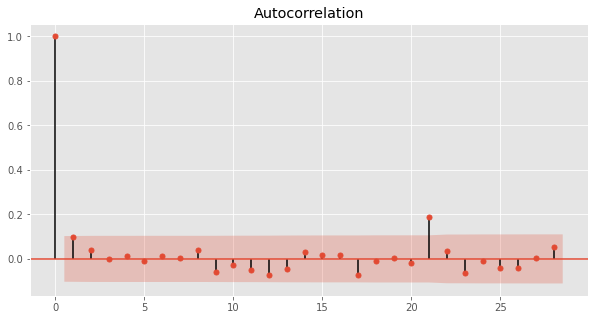

In [ ]:
#plt.figure(figsize(16,5))
sm.graphics.tsa.plot_acf(best_model_1.resid.values.squeeze(), lags=28)
plt.show()

Все остатки статистически не отличимы от нуля.

**Итого:** по всем трём формальным тестам остатков наша модель модет быть засчитана как хорошая.

In [ ]:
df_1.tail()

,Births,Births_diff
Date,,
1959-12-27,37,-5.0
1959-12-28,52,-1.0
1959-12-29,48,9.0
1959-12-30,55,15.0
1959-12-31,50,12.0


In [ ]:
# прогноз на 12м вперёд
import datetime
from dateutil.relativedelta import relativedelta

df_1['model'] = best_model_1.fittedvalues #inv_boxcox(best_model_1.fittedvalues, lmbd)
plot_data1 = df_1[['Births', 'model']]

date_list1 = [datetime.datetime.strptime("1960-01-01", "%Y-%m-%d") + relativedelta(days=x) 
             for x in range(0,30)]
future1 = pd.DataFrame(index=date_list1, columns= plot_data1.columns)
plot_data1 = pd.concat([plot_data1, future1])

plot_data1.tail()

,Births,model
1960-01-26,NaN,NaN
1960-01-27,NaN,NaN
1960-01-28,NaN,NaN
1960-01-29,NaN,NaN
1960-01-30,NaN,NaN


In [ ]:
forecast1 = best_model_1.predict(start=df_1.shape[0], end=df_1.shape[0]+29) #inv_boxcox(best_model_1.predict(start=df_1.shape[0], end=df_1.shape[0]+29), lmbd)
forecast1.index = date_list1

plot_data1.loc[date_list1, 'model'] = forecast1

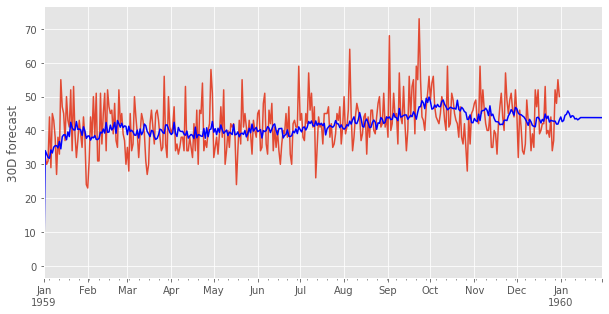

In [ ]:
plot_data1.Births.plot()
plot_data1.model.plot(color='b')
plt.ylabel('30D forecast')
plt.show()

## shampoo

,Sales
Date,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3


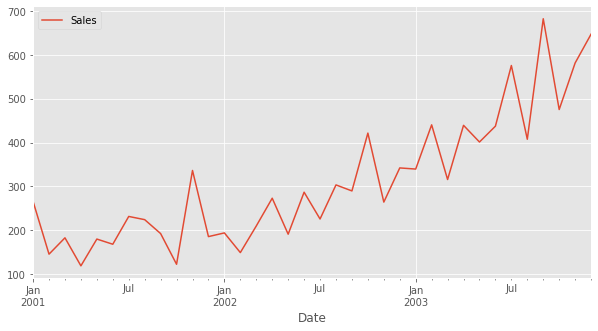

In [ ]:
df_2 = pd.read_csv('/content/drive/MyDrive/Math & Natural & Finance/Math/Statistics/data/shampoo.csv')
df_2['Date'] = pd.to_datetime('200'+df_2['Month']+'-01')
df_2 = df_2.set_index('Date').drop('Month',axis=1)
df_2.plot();
df_2.head()

In [ ]:
from statsmodels.tsa.stattools import adfuller
X = df_2.Sales
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.060142
p-value: 1.000000
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


Тест Дики-Фуллера показал, что ряд *нестационарен* (`p-value = 1` - не отвергаем нулевую гипотезу о нестационарности): виден устойчивый возрастающий тренд и непостоянная диспепрсии. При этом *сезонность не наблюдается*.

Графики Автокорреляции и Частной автокорреляции подверждают эти выводы: видна медленно угасающая зависимость от далее расположенных наблюдений и (в незначительной степени) проявление сезонности на лагах $12-24$ на графике Автокорреляционной функции: 

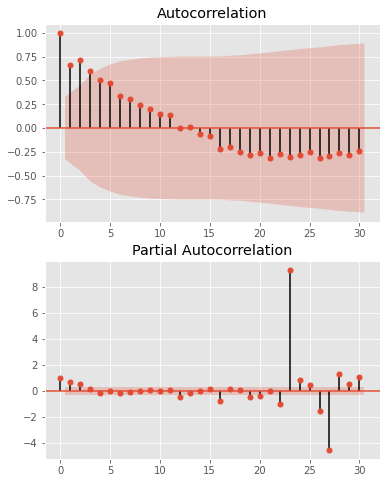

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(6,8)) 

sm.graphics.tsa.plot_acf(df_2['Sales'], lags=30, ax=ax1)
sm.graphics.tsa.plot_pacf(df_2['Sales'], lags=30, ax=ax2)

plt.show()

Тренд пропал - это хорошо. Теперь попробуем "устаканить" дисперсию:

In [ ]:
df_2['Sales_var'], lmbd = stats.boxcox(df_2['Sales'])

In [ ]:
print("Оптимальный параметр преобразования Бокса-Кокса: ",lmbd)

Оптимальный параметр преобразования Бокса-Кокса:  -0.09471316578026066


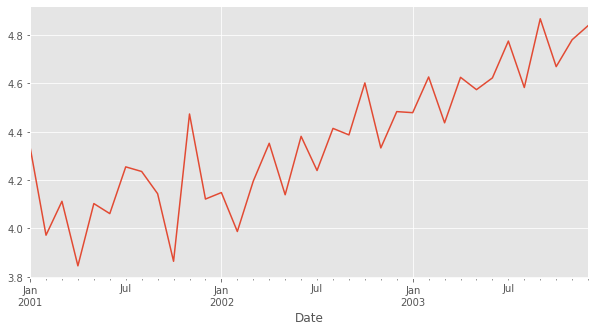

In [ ]:
df_2.Sales_var.plot()

По сравнению с изначальным графиком дисперсия, как будто, не поменялась, но после применения дифференцирования эта разница ощутима: без Бокса-Кокса дисперсия больше, чем с Боксом-Коксом.  
От них можно избавиться, применив дифференциирование (разности соседних наблюдений).

Используя метод эмпирического анализа \*просто перебирает разные лаги)))))\* , наилучший результат получился при взятии разности *двух соседних наблюдений*: сдвиг на 1.

In [ ]:
df_2['Sales_diff'] = df_2.Sales_var - df_2.Sales_var.shift(1)

In [ ]:
df_2['Sales_diff2'] = df_2.Sales_diff - df_2.Sales_diff.shift(1)

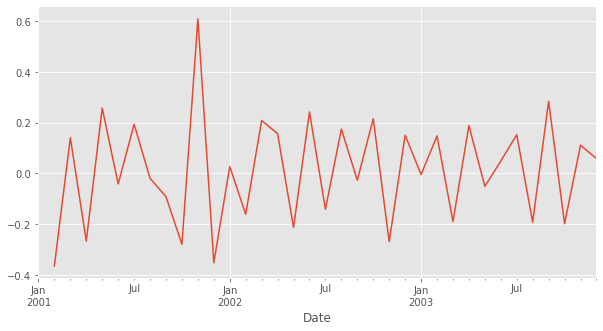

In [ ]:
df_2.Sales_diff.plot()

Проверим наш заключение формально: проведём ещё один тест Дики-Фуллера:

In [ ]:
result = adfuller(df_2.Sales_diff[2:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.387518
p-value: 0.000312
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636


Тест Дики-Фуллера показал, что ряд *стационарен* (`p-value = 0` - отвергнем нулевую гипотезу о нестационарности).

Чтобы выбрать начальные значения для $p,q$ и $P,Q$, необходимо построить графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF).

Графики Автокорреляции и Частной автокорреляции подверждают эти выводы. Статистически ненулевая связь, вообще говоря, только со следующим наблюдением.

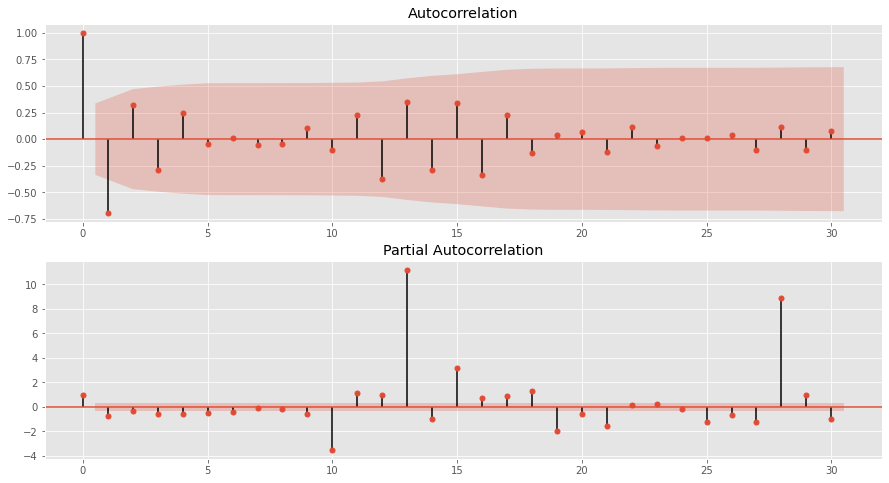

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(df_2.Sales_diff[2:], lags=30, ax=ax1)
sm.graphics.tsa.plot_pacf(df_2.Sales_diff[2:], lags=30, ax=ax2)

plt.show()

**PACF**: $p = 2$, $P = 0$  
**ACF**: $q = 2$, $Q = 0$

In [ ]:
# создадим список из значений параметров для перебора моделей

s = 12 # сезонность
d = D = 1
ps = range(0, 2+1)
qs = range(0, 2+1)

Ps = range(0, 0+1)
Qs = range(0, 0+1)

parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# SARIMAX(p,d,q)x(P,D,Q,s)
results = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in tqdm(parameters_list):
    #try-except нужен, чтобы обработать случаи, когда модель не обучается
    p, q, P, Q = param
    try:
        model=sm.tsa.statespace.SARIMAX(df_2.Sales,  ### Achtung!!! Bitte, vergessen Sie nicht das DF zu verändern.
            order=(p, d, q), 
            seasonal_order=(P, D, Q, s)).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']

result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
2,"(0, 2, 0, 0)",279.174065
5,"(1, 2, 0, 0)",281.158350
8,"(2, 2, 0, 0)",283.030734
4,"(1, 1, 0, 0)",286.062988
3,"(1, 0, 0, 0)",287.696312


Лучшей моделью получилась вторая модель **SARIMA (0,1,2)x(0,0,0)**.

In [ ]:
best_model_2 = sm.tsa.statespace.SARIMAX(df_2.Sales, 
                                     order=(1,1,2), 
                                     seasonal_order=(0,0,0,0)).fit(disp=-1)

In [ ]:
print(best_model_2.summary())

                           Statespace Model Results                           
Dep. Variable:                  Sales   No. Observations:                   36
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -196.631
Date:                Mon, 04 Jul 2022   AIC                            401.263
Time:                        08:34:29   BIC                            407.484
Sample:                    01-01-2001   HQIC                           403.411
                         - 12-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0894      0.346      0.258      0.796      -0.589       0.768
ma.L1         -1.3186      2.951     -0.447      0.655      -7.103       4.466
ma.L2          0.9944      4.393      0.226      0.8

Последний этап - это проанализировать residuals. Нужно показать, что остатки несмещены, стационарны и неавтокоррелированы. 

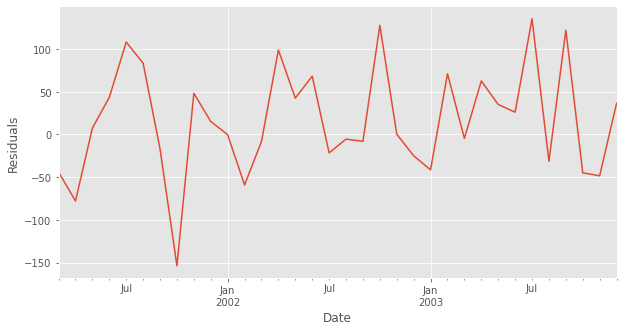

In [ ]:
best_model_2.resid[2:].plot()
plt.ylabel('Residuals')
plt.show()

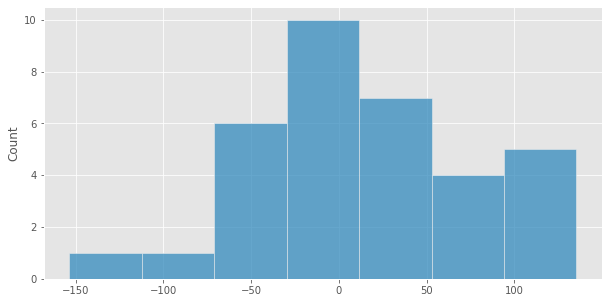

In [ ]:
sns.histplot(best_model_2.resid[2:]);

Визуально остатки выглядят неплохо. Но видны некоторые признаки нестационарности: по графику видно, что модель хуже предсказывает значения в конце выборки. Возможно, они единичны, поэтому их влияние минорно.

**Несмещенность.** Проверим несмещенность с помощью критерия знаков (самый универсальный критерий).

In [ ]:
from statsmodels.stats.descriptivestats import sign_test
print("Критерий знаков для остатков: pvalue =",
      sign_test(best_model_2.resid[2:])[1])

Критерий знаков для остатков: pvalue = 0.8641662404406815


Нулевая гипотеза (одно распределение) не отвергается - остатки несмещены.

**Стационарность.** Проверим стационарность с помщью критерия Дики-Фуллера.

In [ ]:
print("Критерий Дики-Фуллера для остатков: pvalue =",
      sm.tsa.stattools.adfuller(best_model_2.resid[2:])[1])

Критерий Дики-Фуллера для остатков: pvalue = 6.842320059841229e-07


Отвергаем нулевую гипотезу (нестационарность).

**Неавтокоррелированность.** Чтобы определить независимость остаткок, посмотрим на график автокорреляционной функции.

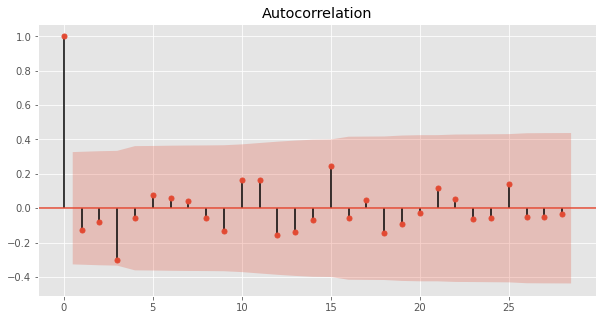

In [ ]:
#plt.figure(figsize(16,5))
sm.graphics.tsa.plot_acf(best_model_2.resid.values.squeeze(), lags=28)
plt.show()

Все остатки статистически не отличимы от нуля.

**Итого:** по всем трём формальным тестам остатков наша модель модет быть засчитана как хорошая. (неожиданно)

In [ ]:
df_2.tail()

,Sales,Sales_var,Sales_diff,Sales_diff2
Date,,,,
2003-08-01,407.6,4.582806,-0.192071,-0.344340
2003-09-01,682.0,4.867137,0.284331,0.476401
2003-10-01,475.3,4.669140,-0.197997,-0.482328
2003-11-01,581.3,4.780367,0.111227,0.309224
2003-12-01,646.9,4.838585,0.058218,-0.053009


In [ ]:
# прогноз на 3м вперёд
import datetime
from dateutil.relativedelta import relativedelta

df_2['model'] = best_model_2.fittedvalues #inv_boxcox(best_model_2.fittedvalues, lmbd)
plot_data2 = df_2[['Sales', 'model']]

date_list2 = [datetime.datetime.strptime("2004-01-01", "%Y-%m-%d") + relativedelta(months=x) 
             for x in range(0,3)]
future2 = pd.DataFrame(index=date_list2, columns= plot_data2.columns)
plot_data2 = pd.concat([plot_data2, future])

plot_data2.tail()

,Sales,model,value
2009-02-01,NaN,NaN,NaN
2009-03-01,NaN,NaN,NaN
2009-04-01,NaN,NaN,NaN
2009-05-01,NaN,NaN,NaN
2009-06-01,NaN,NaN,NaN


In [ ]:
forecast2 =  best_model_2.predict(start=df_2.shape[0], end=df_2.shape[0]+2)  #inv_boxcox(best_model_2.predict(start=df_2.shape[0], end=df_2.shape[0]+2), lmbd)
forecast2.index = date_list2

plot_data2.loc[date_list, 'model'] = forecast2

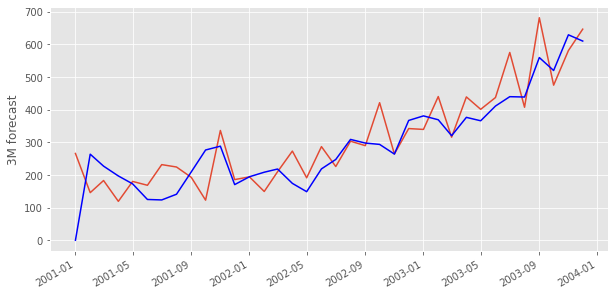

In [ ]:
plot_data2.Sales.plot()
plot_data2.model.plot(color='b')
plt.ylabel('3M forecast')
plt.show()